In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import numpy as np
from numpy import  eye
from pytreenet.operators import TensorProduct, Hamiltonian, pauli_matrices
from pytreenet.ttno import TreeTensorNetworkOperator

from pytreenet.time_evolution.bug import BUG
from pytreenet.time_evolution.exact_time_evolution import ExactTimeEvolution
from pytreenet.time_evolution.ttn_time_evolution import TTNTimeEvolutionConfig


In [3]:
# Question: How to get the dimension of the node?
dim = 2
identity = eye(dim)

# TODO: Remove these two
hadamard_time_step_size = 0.01
final_time = 10

X, Y, Z = pauli_matrices()


In [4]:
def generate_z_operator(node_id):
    sq_op_id = "SQ_Operator"
    sq_z_op = {sq_op_id: TensorProduct({node_id: Z})}
    return sq_z_op

### Binary Tree 


In [5]:
import pytreenet as ptn

def create_binary_tree(num_nodes):
    ttns = ptn.TreeTensorNetworkState()

    if num_nodes < 1:
        raise ValueError("The number of nodes must be at least 1.")

    zero_state = np.zeros((2,), dtype=complex)
    zero_state[0] = 1.0

    root_tensor = np.zeros((2, 2, 2), dtype=complex)
    root_tensor[:, :, 0] = zero_state.reshape(1, 1, 2)
    root_node = ptn.Node(identifier="site0")
    ttns.add_root(root_node, root_tensor)

    nodes = [("site0", root_node, root_tensor)]
    current_node_count = 1
    level_count = 0

    while current_node_count < num_nodes:
        parent_name = nodes.pop(0)[0]

        if current_node_count < num_nodes:
            left_name = f"site{current_node_count}"
            left_shape = (
                (2, 2) if (current_node_count * 2 + 1 >= num_nodes) else (2, 2, 2, 2)
            )
            left_tensor = np.zeros(left_shape, dtype=complex)
            left_tensor[..., 0] = zero_state
            left_child = ptn.Node(identifier=left_name)
            ttns.add_child_to_parent(left_child, left_tensor, 0, parent_name, 1)

            nodes.append((left_name, left_child, left_tensor))
            current_node_count += 1

        if current_node_count < num_nodes:
            right_name = f"site{current_node_count}"
            right_shape = (
                (2, 2) if (current_node_count * 2 + 1 >= num_nodes) else (2, 2, 2, 2)
            )
            right_tensor = np.zeros(right_shape, dtype=complex)
            right_tensor[..., 0] = zero_state
            right_child = ptn.Node(identifier=right_name)
            ttns.add_child_to_parent(right_child, right_tensor, 1, parent_name, 2)

            nodes.append((right_name, right_child, right_tensor))
            current_node_count += 1

        level_count += 1
    return ttns


binary_tree = create_binary_tree(2)

for ident, node in binary_tree.nodes.items():
    print(ident, node.children, node.open_legs)

site0 ['site1'] [1, 2]
site1 [] [1]


## Single Qubit Gate Simulation

In [6]:
def apply_single_qubit_gate(ttns, node_id, gate_hamiltonian):
    # Bug - USE THIS ONE
    term = TensorProduct({node_id: "gate_to_apply"})
    conv_dict = {"I2": identity, "gate_to_apply": gate_hamiltonian}
    hamiltonian = Hamiltonian(term, conversion_dictionary=conv_dict)
    ttno = TreeTensorNetworkOperator.from_hamiltonian(hamiltonian, ttns)

    z_operator = generate_z_operator(node_id)
    bug = BUG(ttns, ttno, hadamard_time_step_size, final_time, z_operator)

    bug.run()

    # # Exact time evolution
    # ref_operator = {"SQ_Operator": Z}
    # exact_evo = ExactTimeEvolution(
    #     ttns, gate_hamiltonian, time_step_size, final_time, ref_operator
    # )
    # exact_evo.run()
    
    return ttns
    

## Two Qubit Gate Simulation

In [7]:
def apply_two_qubit_gate(ttns, control_id, target_id, gate_name):
    term = None
    control_op = None
    target_op = None
    conv_dict = None
    hamiltonian = None
    ttno = None
    match gate_name:
        case "CNOT":
            term = TensorProduct({control_id: "control_op", target_id: "target_op"})
            control_op = eye(dim) - Z
            target_op = eye(dim) - X
            conv_dict = {
                "I2": identity,
                "control_op": control_op,
                "target_op": target_op,
            }
            hamiltonian = Hamiltonian(term, conversion_dictionary=conv_dict)
        case "SWAP":
            term = [
                TensorProduct({control_id: "X", target_id: "X"}),
                TensorProduct({control_id: "Y", target_id: "Y"}),
                TensorProduct({control_id: "Z", target_id: "Z"}),
                TensorProduct({control_id: "I2", target_id: "I2"}),
            ]
            conversion_dict = {"X": X, "Y": Y, "Z": Z, "I2": identity}
            hamiltonian = Hamiltonian(
                term,
                conversion_dictionary=conversion_dict,
            )

    tq_ops = {
        control_id: TensorProduct({control_id: Z}),
        target_id: TensorProduct({target_id: Z}),
    }

    ttno = TreeTensorNetworkOperator.from_hamiltonian(hamiltonian, ttns)
    config = TTNTimeEvolutionConfig(record_bond_dim=True)
    final_time = 2 * 3.2
    bug = BUG(ttns, ttno, hadamard_time_step_size, final_time, tq_ops, config=config)

    bug.run()
    return ttns

In [8]:
def apply_gate(ttns, gate_name, *qubit_ids):
    X, Y, Z = pauli_matrices()
    H = (1 / np.sqrt(2)) * (X + Z)
    one_qubit_gate_map = {"X": X, "Y": Y, "Z": Z, "H": H}
    two_qubit_gate = ["CNOT", "SWAP"]
    if gate_name in one_qubit_gate_map:
        node_id = qubit_ids[0]
        gate_hamiltonian = one_qubit_gate_map[gate_name]
        ttns.apply_single_qubit_gate(ttns, node_id, gate_hamiltonian)
    elif gate_name in two_qubit_gate:
        control_id, target_id = qubit_ids
        ttns.apply_two_qubit_gate(ttns, control_id, target_id, gate_name)
    else:
        raise ValueError(f"Unknown gate: {gate_name}")
    return ttns

## Discrete Time Evolution Example

In [9]:
# def discrete_time_evolution(ttns, gate_sequence):
#     for gate in gate_sequence:
#         gate_name = gate[0]
#         qubit_ids = gate[1:]
#         ttns = apply_gate(ttns, gate_name, *qubit_ids)
#     return ttns


# # ttns = create_binary_tree(num_nodes=9)
# gate_sequence = [("X", "0"), ("H", "2"), ("CNOT", "1", "2")]
# final_state = discrete_time_evolution(ttns, gate_sequence)

# Discrete Time Evoltion
### Using the QuantumGate class

In [10]:
from pytreenet.quantum_gates.QuantumGate import (
    CNOTGate,
    ControlledPhaseGate,
    HadamardGate,
    PhaseShiftGate,
    SWAPGate,
    XGate,
    YGate,
    ZGate,
)
from pytreenet.quantum_gates.constants import CONFIG, GATE_CONFIGS, TIME_STEP_SIZE



def apply_gate(
    ttns, gate_name, *qubit_ids, time_step_size, config, phase_shift, final_time
):
    """



    Apply the given quantum gate to the TTN state.




    Args:



        ttns: TreeTensorNetworkState (the quantum state).



        gate_name: Name of the gate ("X", "H", "CNOT", etc.).



        qubit_ids: IDs of the qubits on which the gate acts.




    Returns:



        Updated TTN state after applying the gate.
    """


    gate_classes = {
        "X": XGate(),
        "Y": YGate(),
        "Z": ZGate(),
        "H": HadamardGate(),

        "CNOT": CNOTGate(),
        "SWAP": SWAPGate(),
        "P_phi": PhaseShiftGate(),
        "CP_phi": ControlledPhaseGate(),
    }

    gate = gate_classes.get(gate_name)


    if not gate:

        raise ValueError(f"Unknown gate: {gate_name}")

    if gate_name == "CP_phi":
        if len(qubit_ids) < 2:
            raise ValueError(
                "CNOT gate requires at least one control and one target qubit."
            )
        control_id = qubit_ids[0]
        target_id = qubit_ids[1]

        gate.apply_gate(
            ttns, control_id, target_id, phase_shift, time_step_size, final_time
        )
    if gate_name == "P_phi":
        gate.apply_gate(ttns, qubit_ids[0], phase_shift, time_step_size, final_time)

    elif len(qubit_ids) == 1:

        gate.apply_gate(ttns, qubit_ids[0], time_step_size, final_time)

    elif len(qubit_ids) == 2:

        print(f"Config: {config}, Final Time: {final_time}")
        gate.apply_gate(
            ttns,
            qubit_ids[0],
            qubit_ids[1],
            time_step_size,
            config,
            final_time,
        )


    else:

        raise ValueError("Unsupported number of qubits for the gate.")

    return ttns

In [11]:
from pytreenet.quantum_gates.constants import FINAL_TIME, PHASE_SHIFT


def discrete_time_evolution(ttns, gate_sequence):
    """
    Apply a sequence of quantum gates to the TTN state.

    Args:
        ttns: TreeTensorNetworkState (the quantum state).
        gate_sequence: List of tuples, where each tuple specifies a gate name,
                       qubit IDs, and optionally time_step_size/config.

    Returns:
        Updated TTN state after the sequence of gates is applied.
    """
    for gate in gate_sequence:
        gate_name = gate[0]

        gate_config = GATE_CONFIGS[gate_name]
        default_time_step_size = gate_config[TIME_STEP_SIZE]
        default_config = gate_config[CONFIG]
        default_final_time = gate_config[FINAL_TIME]

        qubit_ids = gate[1:-1] if isinstance(gate[-1], dict) else gate[1:]
        params = gate[-1] if isinstance(gate[-1], dict) else {}

        time_step_size = params.get(TIME_STEP_SIZE, default_time_step_size)
        config = params.get(CONFIG, default_config)
        phase_shift = params.get(PHASE_SHIFT, None)
        final_time = params.get(FINAL_TIME, default_final_time)

        ttns = apply_gate(
            ttns,
            gate_name,
            *qubit_ids,
            time_step_size=time_step_size,
            config=config,
            phase_shift=phase_shift,
            final_time=final_time,
        )

    return ttns

In [12]:
from pytreenet.quantum_gates.constants import PHASE_SHIFT
from pytreenet.time_evolution.bug import BUGConfig


gate_sequence = [
    ("X", "1", {CONFIG: BUGConfig(record_bond_dim=True)}),
    ("Y", "2", {}),
    ("Z", "3", {TIME_STEP_SIZE: 0.2, CONFIG: BUGConfig(record_bond_dim=True)}),
    ("H", "0"),
    ("SWAP", "1", "2", {CONFIG: BUGConfig(record_bond_dim=True)}),
    ("P_phi", "1", {PHASE_SHIFT: 2}),
]



# ttns = create_binary_tree(num_nodes=4)


# final_state = discrete_time_evolution(ttns, gate_sequence)


# print(final_state)

## Test gates

### X-Gate

100%|██████████| 158/158 [00:00<00:00, 3530.52it/s]


TTN tensors after state preparation:
{'Node': array([0.00079633+0.j        , 0.        -0.99999968j])}
Sanity Check:  True


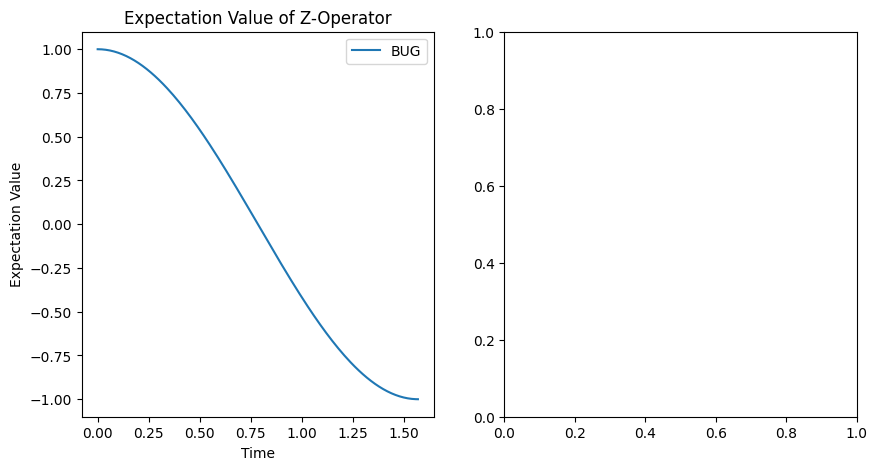

In [13]:
from pytreenet.core.node import Node
from pytreenet.ttns.ttns import TreeTensorNetworkState


y_gate = XGate()
dim = 2
node_id = "Node"
sq_state = np.asarray([1.0, 0.0], dtype=complex)
sq_node = Node(identifier=node_id)
sq_ttns = TreeTensorNetworkState()
sq_ttns.add_root(sq_node, sq_state)

new_ttns = y_gate.apply_gate(
    sq_ttns, node_id, time_step_size=0.01, final_time=np.pi / 2
)


print("TTN tensors after state preparation:")
print(new_ttns.tensors)

y_gate.plot()

### Y-Gate

100%|██████████| 158/158 [00:00<00:00, 3468.58it/s]


TTN tensors after state preparation:
{'Node': array([7.96326711e-04+0.j, 9.99999683e-01+0.j])}
Sanity Check:  True


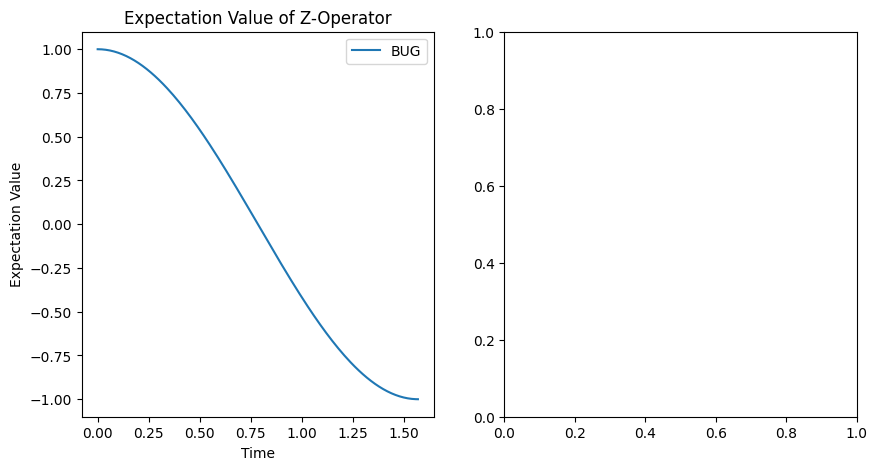

In [14]:
from pytreenet.core.node import Node
from pytreenet.ttns.ttns import TreeTensorNetworkState


y_gate = YGate()
dim = 2
node_id = "Node"
sq_state = np.asarray([1.0, 0.0], dtype=complex)
sq_node = Node(identifier=node_id)
sq_ttns = TreeTensorNetworkState()
sq_ttns.add_root(sq_node, sq_state)

new_ttns = y_gate.apply_gate(
    sq_ttns, node_id, time_step_size=0.01, final_time=np.pi / 2
)


print("TTN tensors after state preparation:")
print(new_ttns.tensors)

y_gate.plot()


### Z-Gate

100%|██████████| 158/158 [00:00<00:00, 3324.97it/s]

TTN tensors after state preparation:
{'Node': array([0.00079633-0.99999968j, 0.        +0.j        ])}
Sanity Check:  True


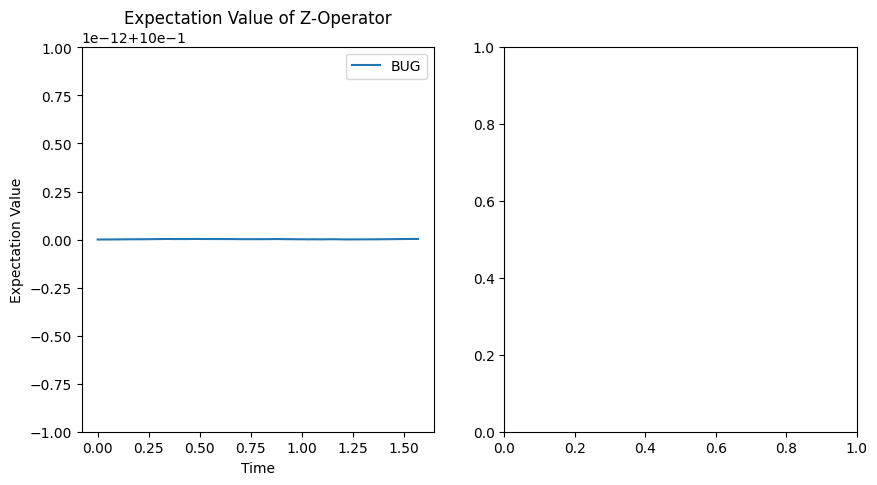

In [15]:
from pytreenet.core.node import Node
from pytreenet.ttns.ttns import TreeTensorNetworkState


y_gate = ZGate()
dim = 2
node_id = "Node"
sq_state = np.asarray([1.0, 0.0], dtype=complex)
sq_node = Node(identifier=node_id)
sq_ttns = TreeTensorNetworkState()
sq_ttns.add_root(sq_node, sq_state)

new_ttns = y_gate.apply_gate(
    sq_ttns, node_id, time_step_size=0.01, final_time=np.pi / 2
)


print("TTN tensors after state preparation:")
print(new_ttns.tensors)

y_gate.plot()

## Hadamard Gate

100%|██████████| 158/158 [00:00<00:00, 3355.41it/s]

TTN tensors after state preparation:
{'Node': array([0.00079633-0.70710656j, 0.        -0.70710656j])}
Sanity Check:  True


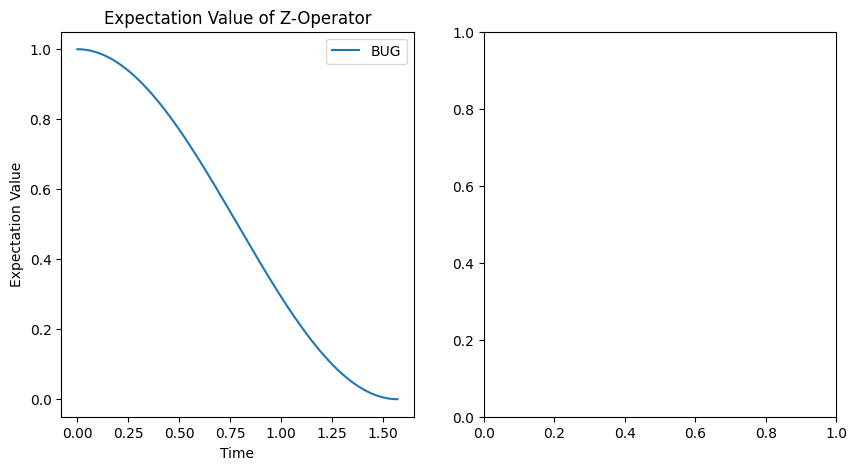

In [16]:
from pytreenet.core.node import Node
from pytreenet.ttns.ttns import TreeTensorNetworkState


y_gate = HadamardGate()
dim = 2
node_id = "Node"
sq_state = np.asarray([1.0, 0.0], dtype=complex)
sq_node = Node(identifier=node_id)
sq_ttns = TreeTensorNetworkState()
sq_ttns.add_root(sq_node, sq_state)

new_ttns = y_gate.apply_gate(
    sq_ttns, node_id, time_step_size=0.01, final_time=np.pi / 2
)


print("TTN tensors after state preparation:")
print(new_ttns.tensors)

y_gate.plot()

### CNOT Gate

100%|██████████| 80/80 [00:00<00:00, 714.24it/s]


TTN tensors after state preparation:
{'Qubit0': array([[ 0.50229562+2.75485019e-30j,  0.0046229 +5.02274342e-01j],
       [ 0.4976938 -4.32280092e-30j, -0.00458055-4.97672717e-01j]]), 'Qubit1': array([[ 7.10353272e-01+1.25556539e-17j,  8.02510237e-14-7.03845316e-01j],
       [ 7.03845316e-01+1.98266985e-17j, -8.10005022e-14+7.10353272e-01j]])}
Sanity Check:  True


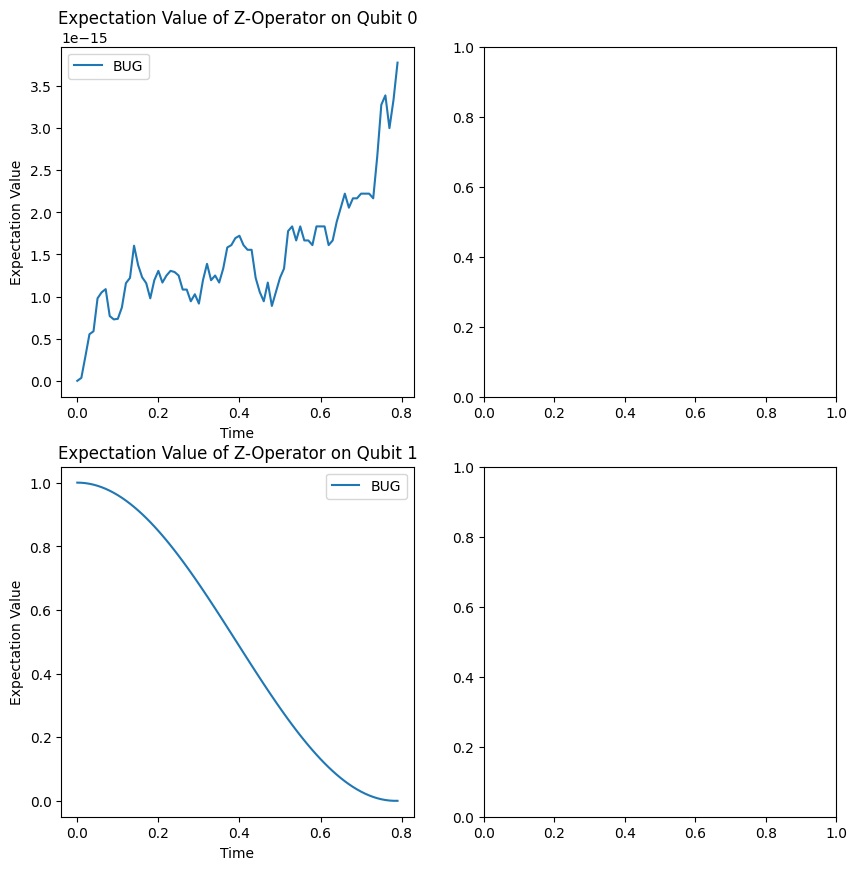

In [17]:
swap_gate = CNOTGate()

dim = 2
init_state_0 = (1 / np.sqrt(2)) * np.asarray([1.0, 1.0], dtype=complex)
init_state_0 = init_state_0.reshape(1, dim)
init_state_1 = np.asarray([1.0, 0.0], dtype=complex)
init_state_1 = init_state_1.reshape(1, dim)

qubit0_id = "Qubit0"
node_0 = Node(identifier=qubit0_id)
qubit1_id = "Qubit1"
node_1 = Node(identifier=qubit1_id)

tq_ttns = TreeTensorNetworkState()
tq_ttns.add_root(node_0, init_state_0)
tq_ttns.add_child_to_parent(node_1, init_state_1, 0, qubit0_id, 0)
config = BUGConfig(record_bond_dim=True)
time_step_size = 0.01
final_time = np.pi / 4
new_ttns = swap_gate.apply_gate(
    tq_ttns,
    qubit0_id,
    qubit1_id,
    time_step_size,
    config,
    final_time,
)

print("TTN tensors after state preparation:")
print(new_ttns.tensors)

swap_gate.plot(qubit0_id, qubit1_id)

### SWAP Gate

100%|██████████| 80/80 [00:00<00:00, 716.21it/s]


TTN tensors after state preparation:
{'Qubit0': array([[ 1.32654826e-16+8.57854158e-20j, -2.16921270e-01+9.76145715e-01j],
       [ 9.20354327e-03-6.16297582e-33j,  3.83350375e-17-1.50922728e-16j]]), 'Qubit1': array([[-9.76187060e-01+2.16930458e-01j,  1.69879182e-16-2.70365167e-16j],
       [-1.14225409e-16-2.49598657e-16j, -1.00000000e+00+1.98446019e-15j]])}
Sanity Check:  True


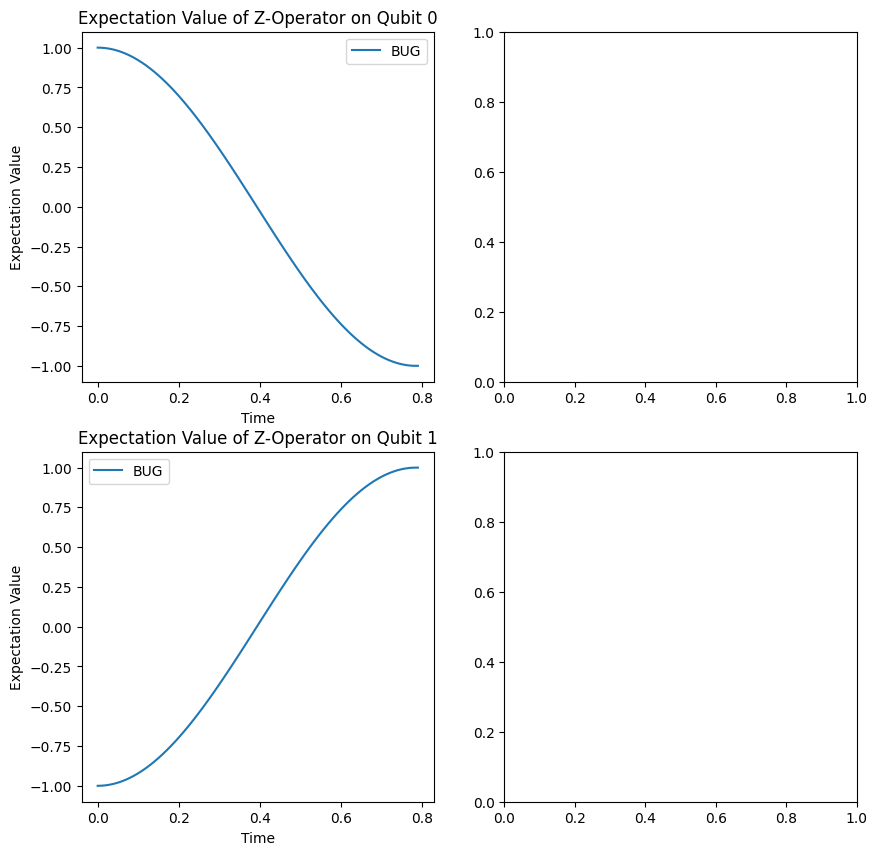

In [18]:
swap_gate = SWAPGate()

dim = 2

init_state_0 = np.asarray([1.0, 0.0], dtype=complex)
init_state_0 = init_state_0.reshape(1, dim)

init_state_1 = np.asarray([0.0, 1.0], dtype=complex)
init_state_1 = init_state_1.reshape(1, dim)

qubit0_id = "Qubit0"
node_0 = Node(identifier=qubit0_id)
qubit1_id = "Qubit1"
node_1 = Node(identifier=qubit1_id)

tq_ttns = TreeTensorNetworkState()
tq_ttns.add_root(node_0, init_state_0)
tq_ttns.add_child_to_parent(node_1, init_state_1, 0, qubit0_id, 0)

config = BUGConfig(record_bond_dim=True)
time_step_size = 0.01
final_time = np.pi / 4

new_ttns = swap_gate.apply_gate(
    tq_ttns,
    qubit0_id,
    qubit1_id,
    time_step_size,
    config,
    final_time,
)

new_ttns.completely_contract_tree(to_copy=True)

print("TTN tensors after state preparation:")
print(new_ttns.tensors)

swap_gate.plot(qubit0_id, qubit1_id)

### Bell state circuit

In [ ]:
dim = 2

init_state_0 = np.asarray([1.0, 0.0], dtype=complex)
init_state_0 = init_state_0.reshape(1, dim)

init_state_1 = np.asarray([1.0, 0.0], dtype=complex)
init_state_1 = init_state_1.reshape(1, dim)

qubit0_id = "Qubit0"
node_0 = Node(identifier=qubit0_id)
qubit1_id = "Qubit1"
node_1 = Node(identifier=qubit1_id)

tq_ttns = TreeTensorNetworkState()
tq_ttns.add_root(node_0, init_state_0)
tq_ttns.add_child_to_parent(node_1, init_state_1, 0, qubit0_id, 0)

y_gate = HadamardGate()
swap_gate = CNOTGate()

hadmard_gate_config = GATE_CONFIGS["H"]
hadamard_time_step_size = hadmard_gate_config[TIME_STEP_SIZE]
hadamard_final_time = hadmard_gate_config[FINAL_TIME]

cnot_gate_config = GATE_CONFIGS["CNOT"]
cnot_time_step_size = cnot_gate_config[TIME_STEP_SIZE]
cnot_config = cnot_gate_config[CONFIG]
cnot_final_time = cnot_gate_config[FINAL_TIME]

after_hadamard_ttns = y_gate.apply_gate(
    tq_ttns, qubit0_id, hadamard_time_step_size, hadamard_final_time
)
final_ttns = swap_gate.apply_gate(
    after_hadamard_ttns,
    qubit0_id,
    qubit1_id,
    cnot_time_step_size,
    cnot_config,
    cnot_final_time,
)


print("TTN tensors after state preparation:")


print(final_ttns.completely_contract_tree(to_copy=True)[0].reshape(4))

(
    array(
        [
            [7.96326711e-04 - 7.07106557e-01j, 1.57198917e-15 - 1.24215148e-15j],
            [6.50761016e-03 - 5.98956085e-05j, -6.50761016e-03 - 7.07046661e-01j],
        ]
    ),
    ["Qubit0", "Qubit1"],
)

100%|██████████| 80/80 [00:00<00:00, 714.41it/s]

TTN tensors after state preparation:
(array([[ 7.96326711e-04-7.07106557e-01j,  1.57198917e-15-1.24215148e-15j],
       [ 6.50761016e-03-5.98956085e-05j, -6.50761016e-03-7.07046661e-01j]]), ['Qubit0', 'Qubit1'])


In [20]:
z_operator = np.array([[1, 0], [0, -1]])

s = new_ttns.completely_contract_tree(to_copy=True)

print(s)

(array([[-1.30565812e-16+2.63959375e-17j, -9.20354327e-03+1.82640652e-17j],
       [-2.77555756e-17-9.99957646e-01j,  1.88730354e-16+3.75397519e-16j]]), ['Qubit0', 'Qubit1'])
